This notebook is supplementary material for the paper "A simple Condorcet voting method for Final Four elections" by Wesley H. Holliday (wesholliday@berkeley.edu).

1. Synthetic Elections

   1.1. Percentages for Figure 1  
   1.2. Percentages for Table 2  
   1.3. Violation of independence of clones (Footnote 31)   
   1.4. Violation of composition consistency for IRV (Footnote 32)   
   1.5. Frequency of heavy top cycles (Footnote 33)  

2. Real Elections

   2.1. PrefLib political elections  

   - Nonexistence of ties  
   - Frequencies of types of elections (Table 1) 
   - Frequencies of disagreement with other methods

   2.2. Otis 2022 elections  

   - Nonexistence of ties  
   - Frequencies of types of elections (Table 1)
   - Frequencies of disagreement with other methods

In [7]:
#!pip3 install pref_voting

import pref_voting

from pref_voting.profiles import *
from pref_voting.voting_methods import *
from pref_voting.combined_methods import *
from pref_voting.margin_based_methods import *

from pref_voting.generate_profiles import generate_profile 
from pref_voting.generate_weighted_majority_graphs import generate_edge_ordered_tournament_infinite_limit

from tqdm.notebook import tqdm

import glob
from zipfile import ZipFile
import io
import itertools
from itertools import combinations

import warnings
import numpy as np
from scipy.stats import binomtest
from functools import partial
import os
from pathos.multiprocessing import ProcessingPool as Pool
import pandas as pd
import time

In [8]:
print(pref_voting.__version__)

1.15.0


# 1. Synthetic Elections

## 1.1. Figure 1 percentages

First we create networkx digraphs for the four tournament isomorphism types.

Linear order:


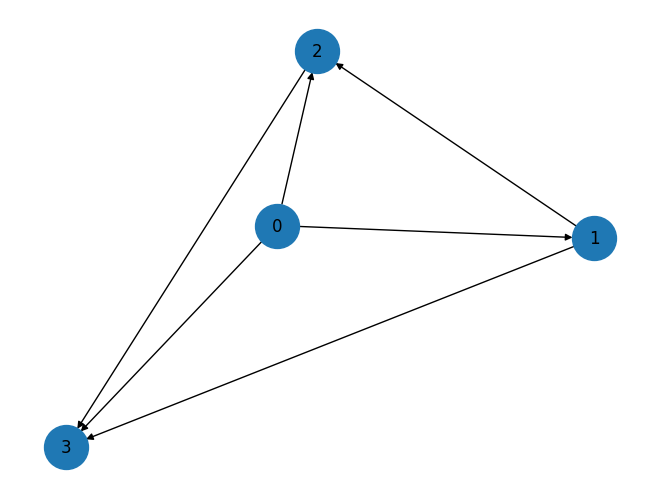

In [9]:
linear_order = nx.DiGraph()
linear_order.add_nodes_from(range(4))
linear_order.add_edges_from([(0,1),(0,2), (0,3), (1,2), (1,3), (2,3)]) 

print("Linear order:")
pos = nx.spring_layout(linear_order)
nx.draw(linear_order, pos, with_labels=True, node_size=1000)

Bottom cycle:


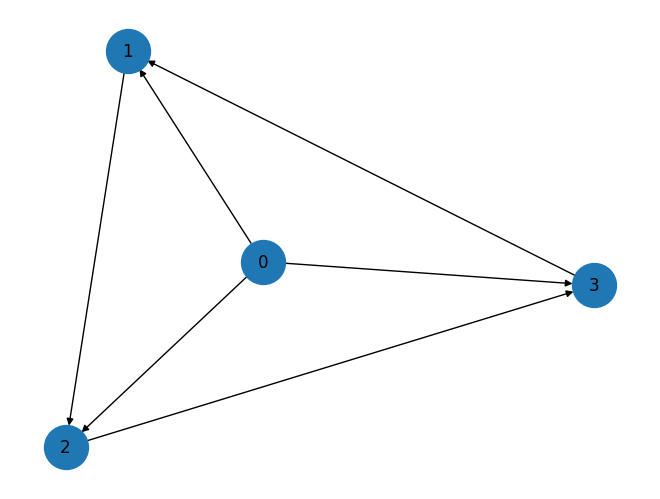

In [10]:
bottom_cycle = nx.DiGraph()
bottom_cycle.add_nodes_from(range(4))
bottom_cycle.add_edges_from([(0,1),(0,2), (0,3), (1,2), (2,3), (3,1)])

print("Bottom cycle:")
pos = nx.spring_layout(bottom_cycle)
nx.draw(bottom_cycle, pos, with_labels=True, node_size=1000)

Top cycle:


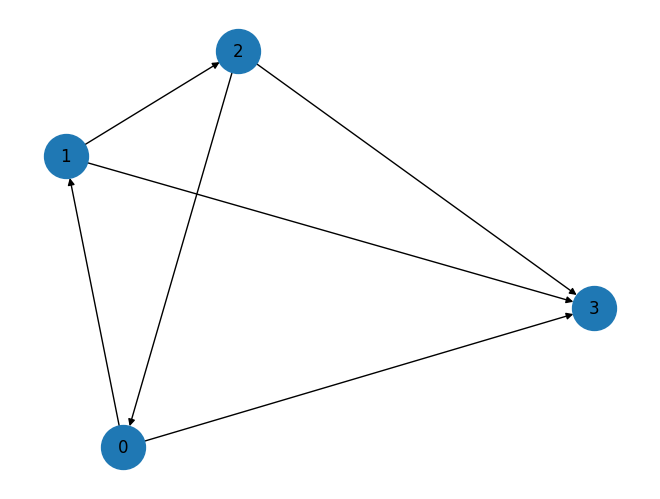

In [11]:
top_cycle_graph = nx.DiGraph()
top_cycle_graph.add_nodes_from(range(4))
top_cycle_graph.add_edges_from([(0,1),(1,2), (2,0), (0,3), (1,3), (2,3)])

print("Top cycle:")
pos = nx.spring_layout(top_cycle_graph)
nx.draw(top_cycle_graph, pos, with_labels=True, node_size=1000)

Four cycle:


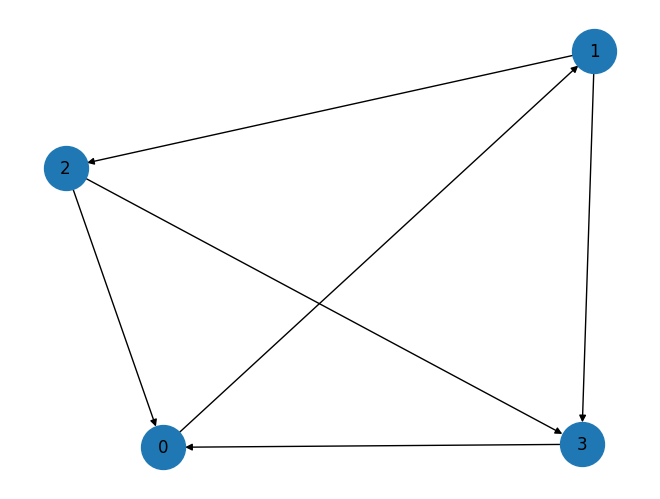

In [12]:
four_cycle = nx.DiGraph()
four_cycle.add_nodes_from(range(4))
four_cycle.add_edges_from([(0,1),(1,2), (2,3), (3,0), (2,0), (1,3)])

print("Four cycle:")
pos = nx.spring_layout(four_cycle)
nx.draw(four_cycle, pos, with_labels=True, node_size=1000)

In [13]:
def binomial_confidence_interval(xs, confidence_level=0.95):
    """
    Computes a two-sided exact binomial confidence interval 
    for the proportion of 1s in a list of 0/1 values.
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        num_success = int(np.sum(xs))
        n = len(xs)
        binom_ci = binomtest(num_success, n).proportion_ci(
            confidence_level=confidence_level,
            method='exact'
        )
    return (binom_ci.low, binom_ci.high)

In [14]:
def record_data_for_one_trial(_):
    """
    Generates an edge-ordered tournament with 4 candidates, 
    checks which of the known isomorphism types it matches, 
    and returns a dictionary with flags indicating the classification.
    """
    mg = generate_edge_ordered_tournament_infinite_limit(4)

    assert mg.is_uniquely_weighted()

    g = nx.DiGraph()
    g.add_nodes_from(range(4))
    directed_edges = [(a,b) for (a,b,c) in mg.edges]
    g.add_edges_from(directed_edges)

    out = {
        "linear_order": 0,
        "bottom_cycle": 0,
        "top_cycle": 0,
        "ascending_top_cycle": 0,
        "descending_top_cycle": 0,
        "four_cycle": 0,
        "SL_four_cycle": 0,
        "LS_four_cycle": 0
    }

    # Check if graph is isomorphic to the linear order
    if nx.is_isomorphic(g, linear_order):
        out["linear_order"] = 1

    # Check if graph is isomorphic to the bottom cycle
    if nx.is_isomorphic(g, bottom_cycle):
        out["bottom_cycle"] = 1

    # Check if graph is isomorphic to the top cycle
    if nx.is_isomorphic(g, top_cycle_graph):
        top_cycle_cands = copeland(mg)
        assert len(top_cycle_cands) == 3

        out["top_cycle"] = 1

        # Identify candidate with the largest margin of victory in top cycle
        max_margin_in_top_cycle = max(
            [mg.margin(c1, c2) 
             for c1 in top_cycle_cands for c2 in top_cycle_cands if c1 != c2]
        )
        top_cycle_cands_with_largest_win = [
            c for c in top_cycle_cands
            if max([mg.margin(c, c2) for c2 in top_cycle_cands]) == max_margin_in_top_cycle
        ]
        assert len(top_cycle_cands_with_largest_win) == 1
        top_cycle_cand_with_largest_win = top_cycle_cands_with_largest_win[0]

        # Identify candidate with the smallest positive margin among top cycle members
        min_pos_margin_in_top_cycle = min(
            [mg.margin(c1, c2)
             for c1 in top_cycle_cands 
             for c2 in top_cycle_cands 
             if mg.margin(c1,c2) > 0]
        )
        top_cycle_cands_with_smallest_loss = [
            c for c in top_cycle_cands
            if min([mg.margin(c2, c) 
                    for c2 in top_cycle_cands if mg.margin(c2,c) > 0]
                   ) == min_pos_margin_in_top_cycle
        ]
        assert len(top_cycle_cands_with_smallest_loss) == 1
        top_cycle_cand_with_smallest_loss = top_cycle_cands_with_smallest_loss[0]

        if top_cycle_cand_with_smallest_loss != top_cycle_cand_with_largest_win:
            out["ascending_top_cycle"] = 1
        else:
            out["descending_top_cycle"] = 1

    # Check if graph is isomorphic to the four cycle
    if nx.is_isomorphic(g, four_cycle):
        copeland_winners = copeland(mg)
        assert len(copeland_winners) == 2

        out["four_cycle"] = 1

        margin_between_copeland_winners = max(
            [mg.margin(c1, c2)
             for c1 in copeland_winners for c2 in copeland_winners]
        )
        margin_of_non_copeland_over_copeland = max(
            [mg.margin(c, c2)
             for c in mg.candidates if c not in copeland_winners
             for c2 in copeland_winners]
        )

        if margin_of_non_copeland_over_copeland < margin_between_copeland_winners:
            out["SL_four_cycle"] = 1
        if margin_of_non_copeland_over_copeland > margin_between_copeland_winners:
            out["LS_four_cycle"] = 1

    return out

In [15]:
def run_experiment_with_parallel_sampling(
    min_num_samples=10_000,
    increment_size=1_000,
    max_num_samples=100_000_000,
    max_error=0.001,
    use_parallel=True,
    num_cpus=None
):
    """
    Collects samples of 4-candidate tournaments in increments, 
    classifies each outcome, and stops once a specified confidence interval width 
    is reached or a maximum sample limit is exceeded.
    """
    start_time = time.time()

    if num_cpus is None:
        num_cpus = os.cpu_count() - 1

    outcome_keys = [
        "linear_order", 
        "bottom_cycle", 
        "top_cycle",
        "ascending_top_cycle", 
        "descending_top_cycle", 
        "four_cycle",
        "SL_four_cycle", 
        "LS_four_cycle"
    ]
    results = {k: [] for k in outcome_keys}
    num_samples = 0

    # Initial CI ranges for each outcome
    error_ranges = [(0, float('inf'))] * len(outcome_keys)

    if use_parallel:
        pool = Pool(num_cpus)
        mapper = pool.map
    else:
        mapper = map

    while True:
        # Collect data for the given increment
        new_data = list(mapper(record_data_for_one_trial, range(increment_size)))

        # Accumulate results
        for d in new_data:
            for key in outcome_keys:
                results[key].append(d[key])
        num_samples += increment_size

        # Compute binomial confidence intervals
        error_ranges = [
            binomial_confidence_interval(results[key])
            for key in outcome_keys
        ]
        widths = [up - low for (low, up) in error_ranges]

        # Check if we meet the conditions to stop
        if num_samples >= min_num_samples and all(w <= max_error for w in widths):
            break
        if num_samples >= max_num_samples:
            break

    print(f"Total Samples Collected: {num_samples}")
    print("=============================================")
    print("Final Percentages:")
    final_counts = {k: sum(results[k]) for k in outcome_keys}

    for k in outcome_keys:
        percentage = (final_counts[k] / num_samples) * 100
        interval_width = widths[outcome_keys.index(k)]
        print(f"{k}: {percentage:.4f}%")

    print("\nApproximate confidence intervals for each outcome proportion:")
    for k, (ci_low, ci_high) in zip(outcome_keys, error_ranges):
        interval_width = ci_high - ci_low
        print(f"  {k}: [{ci_low*100:.4f}%, {ci_high*100:.4f}%] (width={interval_width*100:.6f}%)")

    end_time = time.time()  # End timer
    elapsed_seconds = end_time - start_time
    print("")
    print("Number of CPUs used:", num_cpus)
    print(f"Elapsed time: {elapsed_seconds/60:.2f} minutes")

In [16]:
run_experiment_with_parallel_sampling(
        min_num_samples=100_000, 
        increment_size=100_000,
        max_num_samples=100_000_000,
        max_error=0.0002,
        use_parallel=True
    )

Total Samples Collected: 74100000
Final Percentages:
linear_order: 73.9260%
bottom_cycle: 8.5047%
top_cycle: 8.5258%
ascending_top_cycle: 4.2580%
descending_top_cycle: 4.2677%
four_cycle: 9.0435%
SL_four_cycle: 5.1229%
LS_four_cycle: 3.9206%

Approximate confidence intervals for each outcome proportion:
  linear_order: [73.9160%, 73.9360%] (width=0.019994%)
  bottom_cycle: [8.4984%, 8.5111%] (width=0.012704%)
  top_cycle: [8.5194%, 8.5321%] (width=0.012718%)
  ascending_top_cycle: [4.2535%, 4.2626%] (width=0.009196%)
  descending_top_cycle: [4.2631%, 4.2723%] (width=0.009206%)
  four_cycle: [9.0370%, 9.0500%] (width=0.013062%)
  SL_four_cycle: [5.1178%, 5.1279%] (width=0.010041%)
  LS_four_cycle: [3.9162%, 3.9251%] (width=0.008840%)

Number of CPUs used: 23
Elapsed time: 233.74 minutes


## 1.2. Table 2: frequency of disagreement with other methods

In [28]:
@vm(name = "Proposed Method")
def proposed_method(edata, curr_cands = None):

    if curr_cands is None:
        curr_cands = edata.candidates

    copeland_winners = copeland(edata, curr_cands = curr_cands)

    worst_loss = dict()

    for c in copeland_winners:
        worst_loss[c] = max([edata.margin(c2, c) for c2 in curr_cands])

    smallest_worst_loss = min(worst_loss.values())
    copeland_winners_with_smallest_worst_loss = [c for c in copeland_winners if worst_loss[c] == smallest_worst_loss]

    return copeland_winners_with_smallest_worst_loss

In [12]:
def record_disagreements_for_one_trial(_):
    """
    Generates a random 4-candidate tournament, runs 'proposed_method' 
    and other voting methods, and returns a dictionary indicating whether 
    'proposed_method' disagrees with each method (1 = disagree, 0 = agree).
    """

    # Define proposed_method again inside the function for the parallel case
    @vm(name = "Proposed Method")
    def proposed_method(edata, curr_cands = None):

        copeland_winners = copeland(edata)

        worst_loss = dict()

        for c in copeland_winners:
            worst_loss[c] = max([edata.margin(c2, c) for c2 in edata.candidates])

        smallest_worst_loss = min(worst_loss.values())
        copeland_winners_with_smallest_worst_loss = [c for c in copeland_winners if worst_loss[c] == smallest_worst_loss]

        return copeland_winners_with_smallest_worst_loss

    mg = generate_edge_ordered_tournament_infinite_limit(4)

    pm = proposed_method(mg)
    rp = ranked_pairs(mg)
    mm = minimax(mg)
    smm = smith_minimax(mg)
    bp = beat_path(mg)
    sv = stable_voting(mg)
    rv = river(mg)

    out = {
        "diff_rp": 1 if pm != rp else 0,
        "diff_mm": 1 if pm != mm else 0,
        "diff_smm": 1 if pm != smm else 0,
        "diff_bp": 1 if pm != bp else 0,
        "diff_sv": 1 if pm != sv else 0,
        "diff_rv": 1 if pm != rv else 0,
    }

    return out

In [13]:
def run_disagreement_experiment(
    min_num_samples=10_000,
    increment_size=1_000,
    max_num_samples=100_000_000,
    max_error=0.001,
    use_parallel=True,
    num_cpus=None
):
    """
    Repeatedly samples 4-candidate tournaments, applies 'proposed_method' 
    and other methods, and tracks disagreement frequencies. 
    Sampling stops once we have at least 'min_num_samples' 
    AND all binomial CI widths are < 'max_error', 
    or once 'max_num_samples' is reached.
    """

    start_time = time.time()

    if num_cpus is None:
        num_cpus = os.cpu_count() - 1

    # Each outcome key tracks disagreement with a specific method
    outcome_keys = [
        "diff_rp", 
        "diff_mm", 
        "diff_smm", 
        "diff_bp", 
        "diff_sv", 
        "diff_rv",
    ]

    # Store 0/1 results for each key in lists
    results = {key: [] for key in outcome_keys}
    num_samples = 0

    # Initial confidence intervals (start wide)
    error_ranges = [(0, float('inf'))] * len(outcome_keys)

    # Parallel or serial mapping
    if use_parallel:
        pool = Pool(num_cpus)
        mapper = pool.map
    else:
        mapper = map

    while True:
        # Collect data in increments
        new_data = list(mapper(record_disagreements_for_one_trial, range(increment_size)))
        num_samples += increment_size

        # Accumulate results for each key
        for d in new_data:
            for key in outcome_keys:
                results[key].append(d[key])

        # Compute binomial intervals for each outcome
        error_ranges = [
            binomial_confidence_interval(results[key])
            for key in outcome_keys
        ]
        widths = [(up - low) for (low, up) in error_ranges]

        # Stop once all intervals are sufficiently narrow & min samples are reached
        if num_samples >= min_num_samples and all(w <= max_error for w in widths):
            break
        if num_samples >= max_num_samples:
            break

    # Final statistics
    print(f"Total Samples Collected: {num_samples}")
    print("==================================================")

    # Summaries
    final_counts = {k: sum(results[k]) for k in outcome_keys}

    for k in outcome_keys:
        proportion = final_counts[k] / num_samples
        ci_low, ci_high = binomial_confidence_interval(results[k])
        ci_width = ci_high - ci_low
        print(
            f"{k}: {proportion * 100:.4f}%  "
            f"CI: [{ci_low*100:.4f}%, {ci_high*100:.4f}%]  "
            f"(width={ci_width*100:.4f}%)"
        )

    end_time = time.time()  # End timer
    elapsed_seconds = end_time - start_time
    print("")
    print("Number of CPUs used:", num_cpus)
    print(f"Elapsed time: {elapsed_seconds/60:.2f} minutes")

In [14]:
run_disagreement_experiment(
        min_num_samples=100_000,      
        increment_size=10_000,        
        max_num_samples=100_000_000,
        max_error=0.0001,             
        use_parallel=True            
    )

Total Samples Collected: 33310000
diff_rp: 2.2151%  CI: [2.2101%, 2.2201%]  (width=0.0100%)
diff_mm: 1.7195%  CI: [1.7151%, 1.7239%]  (width=0.0088%)
diff_smm: 1.6323%  CI: [1.6280%, 1.6366%]  (width=0.0086%)
diff_bp: 1.5954%  CI: [1.5912%, 1.5997%]  (width=0.0085%)
diff_sv: 1.5342%  CI: [1.5300%, 1.5384%]  (width=0.0084%)
diff_rv: 1.7683%  CI: [1.7639%, 1.7728%]  (width=0.0090%)

Number of CPUs used: 23
Elapsed time: 158.48 minutes


### Frequency of disagreement with IRV under IC with 1,000 voters

In [15]:
def record_disagreement_with_irv(_):
    """
    Generates a random 4-candidate profile, applies the proposed method 
    and Instant Runoff Voting (IRV), and records whether there is a disagreement.
    
    Returns:
    - 1 if there is a disagreement between the proposed method and IRV, else 0.
    """
    # Define proposed_method again inside the function for the parallel case
    @vm(name = "Proposed Method")
    def proposed_method(edata, curr_cands = None):

        copeland_winners = copeland(edata)

        worst_loss = dict()

        for c in copeland_winners:
            worst_loss[c] = max([edata.margin(c2, c) for c2 in edata.candidates])

        smallest_worst_loss = min(worst_loss.values())
        copeland_winners_with_smallest_worst_loss = [c for c in copeland_winners if worst_loss[c] == smallest_worst_loss]

        return copeland_winners_with_smallest_worst_loss
    
    prof = generate_profile(4, 1000)  # 4 candidates, 1000 voters
    
    pm_result = proposed_method(prof)
    irv_result = instant_runoff(prof)
    
    # Record disagreement
    return 1 if pm_result != irv_result else 0

In [16]:
def run_irv_disagreement_experiment(
    min_num_samples=10_000,
    increment_size=1_000,
    max_num_samples=100_000_000,
    max_error=0.001,
    use_parallel=True,
    num_cpus=None
):
    """
    Estimates the frequency of disagreements between the proposed method and 
    Instant Runoff Voting (IRV) using incremental sampling and parallel processing.
    Sampling stops once the binomial confidence interval width for the estimated 
    frequency is below 'max_error', or once 'max_num_samples' is reached.
    
    Parameters:
    - min_num_samples: Minimum number of samples to collect before considering stopping.
    - increment_size: Number of samples to add in each iteration.
    - max_num_samples: Maximum number of samples to collect.
    - max_error: Maximum allowed width for the confidence interval.
    - use_parallel: Whether to use parallel processing.
    - num_cpus: Number of CPU cores to use (defaults to all available minus one).
    """

    start_time = time.time()

    if num_cpus is None:
        num_cpus = max(os.cpu_count() - 1, 1)  # Ensure at least one CPU
    
    # Initialize result storage
    results = []
    num_samples = 0
    
    # Initialize confidence interval with default wide range
    ci_low, ci_high = (0.0, float('inf'))
    width = ci_high - ci_low
    
    # Set up parallel or serial mapping
    if use_parallel:
        pool = Pool(num_cpus)
        mapper = pool.map
    else:
        mapper = map
    
    # Sampling loop
    while True:
        # Collect new data
        new_data = list(mapper(record_disagreement_with_irv, range(increment_size)))
        results.extend(new_data)
        num_samples += increment_size
        
        # Compute binomial confidence interval for the proportion of disagreements
        ci_low, ci_high = binomial_confidence_interval(results)
        width = ci_high - ci_low
        
        # Check stopping conditions
        if num_samples >= min_num_samples and width <= max_error:
            break
        if num_samples >= max_num_samples:
            break
    
    # Compute final statistics
    proportion = np.mean(results)
    
    # Display results
    print(f"Total Samples Collected: {num_samples}")
    print("==================================================")
    print(f"Frequency of disagreement with IRV: {proportion * 100:.4f}%")
    print(
        f"Approx. confidence interval: "
        f"[{ci_low*100:.4f}%, {ci_high*100:.4f}%], width={width*100:.4f}%"
    )

    end_time = time.time()  # End timer
    elapsed_seconds = end_time - start_time
    print("")
    print("Number of CPUs used:", num_cpus)
    print(f"Elapsed time: {elapsed_seconds/60:.2f} minutes")

In [17]:
run_irv_disagreement_experiment(
        min_num_samples=100_000,      
        increment_size=10_000,         
        max_num_samples=100_000_000, 
        max_error=0.0005,              
        use_parallel=True,             
        num_cpus=None                  
    )

Total Samples Collected: 8680000
Frequency of disagreement with IRV: 16.9880%
Approx. confidence interval: [16.9631%, 17.0130%], width=0.0500%

Number of CPUs used: 23
Elapsed time: 47.52 minutes


## 1.3. Violation of independence of clones (Footnote 31)

In [73]:
from pref_voting.variable_candidate_axioms import tideman_clone_sets

bad_prof = Profile([[1,3,0,2], [0,2,1,3], [2,1,3,0]])
bad_prof.display()

for clones in tideman_clone_sets(bad_prof):
    print("Set of clones:", set(clones))

print("Winners in full profile:", proposed_method(bad_prof))
print("Winners in full profile without 1:", proposed_method(bad_prof, curr_cands = [c for c in bad_prof.candidates if c != 1]))


+---+---+---+
| 1 | 1 | 1 |
+---+---+---+
| 1 | 0 | 2 |
| 3 | 2 | 1 |
| 0 | 1 | 3 |
| 2 | 3 | 0 |
+---+---+---+
Set of clones: {1, 3}
Winners in full profile: [1, 2]
Winners in full profile without 1: [0, 2, 3]


## 1.4. Violation of composition consistency for IRV (Footnote 32)

+---+---+---+---+---+
| 1 | 1 | 1 | 1 | 1 |
+---+---+---+---+---+
| 2 | 2 | 3 | 0 | 3 |
| 1 | 0 | 0 | 1 | 0 |
| 0 | 1 | 1 | 3 | 2 |
| 3 | 3 | 2 | 2 | 1 |
+---+---+---+---+---+


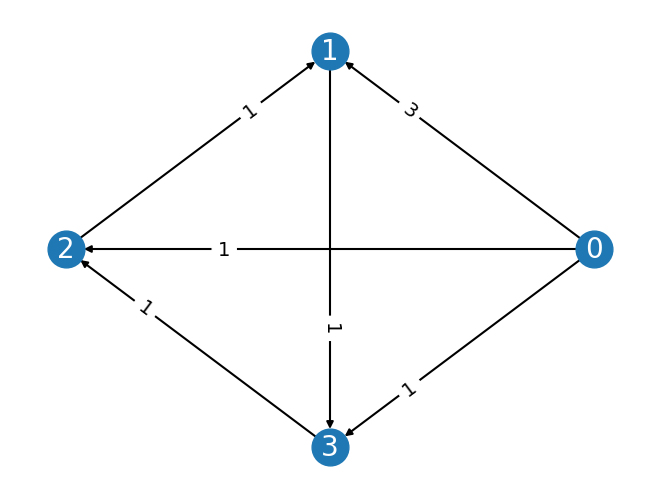

IRV winner: [3]
IRV winners after removing 2: [0]


In [76]:
num_trials = 1000

for n in range(num_trials):
    prof = generate_profile(4, 5)
    mg = prof.margin_graph()
    
    g = nx.DiGraph()
    g.add_nodes_from(range(4))
    directed_edges = [(a,b) for (a,b,c) in mg.edges]
    g.add_edges_from(directed_edges)

    irvws = instant_runoff(prof)

    if nx.is_isomorphic(g, bottom_cycle) and len(irvws) == 1:
        cw = condorcet(mg)[0]

        if cw not in irvws:
            bottom_cycle_cands = [c for c in prof.candidates if c != cw]

            found_ex = False

            for c in bottom_cycle_cands:
                if c not in irvws:  
                    new_irvws = instant_runoff(prof, curr_cands = [d for d in prof.candidates if d != c])
                    if cw in new_irvws:
                        prof.display()
                        prof.display_margin_graph()
                        print("IRV winner:", irvws)
                        print(f"IRV winners after removing {c}:", new_irvws)
                        found_ex = True
                        break
            
            if found_ex:
                break     

## 1.5. Frequency of heavy top cycles (Footnote 33)

In [8]:
def record_heavy_top_cycle(_):
    """
    Generates a 4-candidate tournament. 
    Returns 1 if the outcome qualifies as a 'heavy top cycle', in which the margins between candidates in the top cycle are larger than the margins between the candidates in the top cycle and the condorcet loser,
    and 0 otherwise.
    """
    mg = generate_edge_ordered_tournament_infinite_limit(4)
    mm = minimax(mg)[0]  # Minimax winner
    # 'Heavy top cycle' is defined here as having Copeland score == -3 for mm
    return 1 if mg.copeland_scores()[mm] == -3 else 0

In [9]:
def run_heavy_top_cycle_experiment(
    min_num_samples=10_000,
    increment_size=1_000,
    max_num_samples=100_000_000,
    max_error=0.001,
    use_parallel=True,
    num_cpus=None
):
    """
    Estimates the frequency of 'heavy top cycle' tournaments with 4 candidates.
    Uses incremental sampling and stops once the binomial confidence interval 
    width for the estimated frequency is below 'max_error', or once 
    'max_num_samples' is reached.
    """

    start_time = time.time()

    if num_cpus is None:
        num_cpus = os.cpu_count() - 1

    # Accumulate 0/1 data in this list
    results = []
    num_samples = 0

    # Initial confidence interval
    ci_low, ci_high = (0, float('inf'))

    # Prepare for parallel or serial mapping
    if use_parallel:
        pool = Pool(num_cpus)
        mapper = pool.map
    else:
        mapper = map

    while True:
        # Gather new data in increments
        new_data = list(mapper(record_heavy_top_cycle, range(increment_size)))
        results.extend(new_data)
        num_samples += increment_size

        # Compute binomial confidence interval for the proportion of 1s
        ci_low, ci_high = binomial_confidence_interval(results)
        width = ci_high - ci_low

        # Check stopping conditions
        if num_samples >= min_num_samples and width <= max_error:
            break
        if num_samples >= max_num_samples:
            break

    # Compute final statistics
    proportion = np.mean(results)
    print(f"Total Samples Collected: {num_samples}")
    print("=============================================")
    print(f"Heavy top cycle estimate: {proportion * 100:.4f}%")
    print(
        f"Approx. confidence interval: "
        f"[{ci_low*100:.4f}%, {ci_high*100:.4f}%], width={width*100:.4f}%"
    )

    end_time = time.time()  # End timer
    elapsed_seconds = end_time - start_time
    print("")

    print("Number of CPUs used:", num_cpus)
    print(f"Elapsed time: {elapsed_seconds/60:.2f} minutes")

In [13]:
run_heavy_top_cycle_experiment(
        min_num_samples=100_000,     
        increment_size=10_000,       
        max_num_samples=100_000_000,
        max_error=0.00005,           
        use_parallel=True           
    )

Total Samples Collected: 4870000
Heavy top cycle estimate: 0.0786%
Approx. confidence interval: [0.0761%, 0.0811%], width=0.0050%

Number of CPUs used: 23
Elapsed time: 4.02 minutes


# 2. Real political elections

In [59]:
def find_tie_for_proposed_method(profiles):

    found_tie = False

    for prof in tqdm(profiles):
        prof.use_extended_strict_preference()
        winners = proposed_method(prof)
        
        if len(winners) > 1:
            found_tie = True
            print("Tie in election!")

    if not found_tie:
        print("No ties found.")

In [55]:
def check_profiles_for_types_of_elections(profiles, max_num_candidates):

    count = 0
    profile_count = 0
    num_voters_list = []
    linear_order_count = 0
    bottom_cycle_count = 0
    top_cycle_count = 0
    ascending_top_cycle_count = 0
    descending_top_cycle_count = 0
    light_top_cycle_count = 0
    heavy_top_cycle_count = 0
    four_cycle_count = 0
    SL_four_cycle_count = 0
    LS_four_cycle_count = 0

    for prof in tqdm(profiles):

        prof.use_extended_strict_preference()

        mg = prof.margin_graph()

        if len(prof.candidates) > max_num_candidates:
            continue

        if len(prof.candidates) < 4: 
            continue

        profile_count += 1

        for subset in itertools.combinations(prof.candidates, 4):
                # Create a new profile with only the 4 candidates
                # Skip if there are any zero margins between distinct candidates in the subset
                if any([mg.margin(a,b) == 0 for a in subset for b in subset if a != b]):
                    continue

                count += 1

                # Extract the underlying directed graph from mg
                g = nx.DiGraph()
                g.add_nodes_from(subset)
                directed_edges = [(a,b) for (a,b,c) in mg.edges if a in subset and b in subset]
                g.add_edges_from(directed_edges)

                # Find the appropriate isomorphism type
                if nx.is_isomorphic(g, linear_order):
                    linear_order_count += 1

                if nx.is_isomorphic(g, bottom_cycle):
                    bottom_cycle_count += 1

                if nx.is_isomorphic(g, top_cycle_graph):

                    top_cycle_count += 1

                    top_cycle_cands = copeland(mg, curr_cands = subset)
                    assert len(top_cycle_cands) == 3

                    # Find the candidate in the top cycle with the largest win
                    max_margin_in_top_cycle = max([mg.margin(c1, c2) for c1 in top_cycle_cands for c2 in top_cycle_cands if c1 != c2])
                    top_cycle_cands_with_largest_win = [c for c in top_cycle_cands if max([mg.margin(c, c2) for c2 in top_cycle_cands]) == max_margin_in_top_cycle]
                    assert len(top_cycle_cands_with_largest_win) == 1
                    top_cycle_cand_with_largest_win = top_cycle_cands_with_largest_win[0]

                    # Find the candidate in the top cycle with the smallest loss
                    min_pos_margin_in_top_cycle = min([mg.margin(c1, c2) for c1 in top_cycle_cands for c2 in top_cycle_cands if mg.margin(c1,c2) > 0])
                    top_cycle_cands_with_smallest_loss = [c for c in top_cycle_cands if min([mg.margin(c2, c) for c2 in top_cycle_cands if mg.margin(c2,c) > 0]) == min_pos_margin_in_top_cycle]
                    assert len(top_cycle_cands_with_smallest_loss) == 1
                    top_cycle_cand_with_smallest_loss = top_cycle_cands_with_smallest_loss[0]

                    # check for ascending top cycle
                    if top_cycle_cand_with_smallest_loss != top_cycle_cand_with_largest_win:
                        ascending_top_cycle_count += 1

                    # check for descending top cycle
                    if top_cycle_cand_with_smallest_loss == top_cycle_cand_with_largest_win:
                        descending_top_cycle_count += 1

                    # check for light/heavy top cycle
                    condorcet_loser = mg.condorcet_loser(curr_cands = subset)
                    assert not condorcet_loser == None
                    assert not condorcet_loser in top_cycle_cands
                    
                    margins_between_top_cycle_cands = [mg.margin(c1, c2) for c1 in top_cycle_cands for c2 in top_cycle_cands if c1 != c2 and mg.margin(c1,c2) > 0]
                    assert len(margins_between_top_cycle_cands) == 3
                    margins_between_top_cycle_and_condorcet_loser = [mg.margin(c, condorcet_loser) for c in top_cycle_cands]
                    assert len([m for m in margins_between_top_cycle_and_condorcet_loser if m > 0]) == 3

                    # check for light top cycle
                    if max(margins_between_top_cycle_cands) < min(margins_between_top_cycle_and_condorcet_loser):
                        light_top_cycle_count += 1

                    # check for heavy top cycle
                    if min(margins_between_top_cycle_cands) > max(margins_between_top_cycle_and_condorcet_loser):
                        heavy_top_cycle_count += 1

                if nx.is_isomorphic(g, four_cycle):

                    four_cycle_count += 1
                    
                    copeland_winners = copeland(mg, curr_cands = subset)
                    assert len(copeland_winners) == 2
                    margin_between_copeland_winners = max([mg.margin(c1, c2) for c1 in copeland_winners for c2 in copeland_winners]) 
                    margin_of_non_copeland_over_copeland = max([mg.margin(c, c2) for c in mg.candidates if c not in copeland_winners for c2 in copeland_winners])

                    # check for SL four cycle
                    if margin_of_non_copeland_over_copeland < margin_between_copeland_winners:
                        SL_four_cycle_count += 1

                    # check for LS four cycle
                    if margin_of_non_copeland_over_copeland > margin_between_copeland_winners:
                        LS_four_cycle_count += 1

    assert top_cycle_count == ascending_top_cycle_count + descending_top_cycle_count
    assert four_cycle_count == SL_four_cycle_count + LS_four_cycle_count

    print("Number of profiles:", profile_count)
    print("Number of 4-candidate subprofiles with no zero margins:", count)
    print("")
    print("Linear order:", linear_order_count, (linear_order_count / count) * 100, "%")
    print("")
    print("Bottom cycle:", bottom_cycle_count, (bottom_cycle_count / count) * 100, "%")
    print("")
    print("Top cycle:", top_cycle_count, (top_cycle_count / count) * 100, "%")
    print("Ascending top cycle:", ascending_top_cycle_count, (ascending_top_cycle_count / count) * 100, "%")
    print("Descending top cycle:", descending_top_cycle_count, (descending_top_cycle_count / count) * 100, "%")
    print("Light top cycle:", light_top_cycle_count, (light_top_cycle_count / count) * 100, "%")
    print("Heavy top cycle:", heavy_top_cycle_count, (heavy_top_cycle_count / count) * 100, "%")
    print("")
    print("Four cycle:", four_cycle_count, (four_cycle_count / count) * 100, "%")
    print("SL four cycle:", SL_four_cycle_count, (SL_four_cycle_count / count) * 100, "%")
    print("LS four cycle:", LS_four_cycle_count, (LS_four_cycle_count / count) * 100, "%")

In [46]:
def check_profiles_for_disagreement_with_other_methods(profiles, max_num_candidates):

    profile_count = 0
    count = 0

    diff_rp = 0
    diff_mm = 0
    diff_smm = 0
    diff_bp = 0
    diff_sv = 0

    for prof in tqdm(profiles):

        if len(prof.candidates) > max_num_candidates:
            continue

        if len(prof.candidates) < 4: 
            continue

        profile_count += 1

        prof.use_extended_strict_preference()

        mg = prof.margin_graph()

        for subset in itertools.combinations(prof.candidates, 4):

            # Skip if there are any zero margins between distinct candidates in the subset
            if any([prof.margin(a,b) == 0 for a in subset for b in subset if a != b]):
                continue

            count += 1

            rp = ranked_pairs(mg, curr_cands = subset)
            mm = minimax(mg, curr_cands = subset)
            smm = smith_minimax(mg, curr_cands = subset)
            bp = beat_path(mg, curr_cands = subset)
            sv = stable_voting(mg, curr_cands = subset)
            pm = proposed_method(prof, curr_cands = subset)

            if pm != rp:
                diff_rp += 1
            
            if pm != mm:
                diff_mm += 1

            if pm != smm:
                diff_smm += 1

            if pm != bp:
                diff_bp += 1

            if pm != sv:
                diff_sv += 1

    print("Frequency of disagreement with Ranked Pairs:", diff_rp / count)
    print("Frequency of disagreement with Minimax:", diff_mm / count)
    print("Frequency of disagreement with Smith/Minimax:", diff_smm / count)
    print("Frequency of disagreement with Beat Path:", diff_bp / count)
    print("Frequency of disagreement with Stable Voting:", diff_sv / count)

## 2.1 PrefLib political elections

In this section, we analyze political elections from [PrefLib](https://preflib.simonrey.fr) up to the end of 2024.

In [34]:
preflib_profiles = []
elections = []

for fname in tqdm(glob.glob("real_elections/preflib_dataset/*.soi")):

    election_name = fname.split("/")[-1].split(".")[0]

    if election_name in elections: 
        continue

    elections.append(election_name)
    
    preflib_profiles.append(ProfileWithTies.read(fname))
    
for fname in tqdm(glob.glob("real_elections/preflib_dataset/*.toi")):

    election_name = fname.split("/")[-1].split(".")[0]

    if election_name in elections: 
        continue

    elections.append(election_name)
    preflib_profiles.append(ProfileWithTies.read(fname))

for fname in tqdm(glob.glob("real_elections/preflib_dataset/*.toc")):

    election_name = fname.split("/")[-1].split(".")[0]

    if election_name in elections: 
        continue

    elections.append(election_name)

    elections.append(election_name)
    preflib_profiles.append(ProfileWithTies.read(fname))

  0%|          | 0/308 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

### Nonexistence of ties

In [35]:
find_tie_for_proposed_method(preflib_profiles)

No ties found.


### Frequencies of six types of elections

In [56]:
check_profiles_for_types_of_elections(preflib_profiles, 378)

  0%|          | 0/364 [00:00<?, ?it/s]

Number of profiles: 354
Number of 4-candidate subprofiles with no zero margins: 44323

Linear order: 44295 99.93682738081809 %

Bottom cycle: 14 0.03158630959095729 %

Top cycle: 14 0.03158630959095729 %
Ascending top cycle: 0 0.0 %
Descending top cycle: 14 0.03158630959095729 %
Light top cycle: 11 0.024817814678609298 %
Heavy top cycle: 0 0.0 %

Four cycle: 0 0.0 %
SL four cycle: 0 0.0 %
LS four cycle: 0 0.0 %


### Frequencies of disagreement with other methods

In [38]:
check_profiles_for_disagreement_with_other_methods(preflib_profiles, 378)

  0%|          | 0/364 [00:00<?, ?it/s]

Frequency of disagreement with Ranked Pairs: 0.0
Frequency of disagreement with Minimax: 0.0
Frequency of disagreement with Smith/Minimax: 0.0
Frequency of disagreement with Beat Path: 0.0
Frequency of disagreement with Stable Voting: 0.0


## Otis 2022 dataset

In this section, we analyze elections from the [Otis 2022](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/AMK8PJ) dataset.

In [41]:
# This will take about 15 minutes to run

items_to_skip = [
    'skipped', 
    'overvote', 
    'undervote']

otis_profiles = []

for file in tqdm(glob.glob("real_elections/otis_2022_dataset/*.zip")):

    if not file.endswith(".csv") and not file.endswith(".zip"):
        continue
    # if file ends with .zip unzip the file and process it 
    if file.endswith(".zip"):
        with ZipFile(file, 'r') as zip_ref:
            # Iterate through each file inside the zip
            for name in zip_ref.namelist():
                # Only process .csv files
                if name.endswith(".csv"):
                    with zip_ref.open(name) as f:
                        # Read the CSV data into memory
                        csv_bytes = f.read()
                        # Decode bytes to string
                        csv_text = csv_bytes.decode('utf-8')
                        # Create a file-like StringIO object
                        csv_buffer = io.StringIO(csv_text)

                        # Now pass this StringIO to ProfileWithTies.read
                        prof = ProfileWithTies.read(
                            csv_buffer,
                            file_format='csv',
                            csv_format='rank_columns',
                            items_to_skip=items_to_skip,
                        )
                        otis_profiles.append(prof)

  0%|          | 0/458 [00:00<?, ?it/s]

### Nonexistence of ties

In [60]:
find_tie_for_proposed_method(otis_profiles)

  0%|          | 0/458 [00:00<?, ?it/s]

No ties found.


### Frequencies of types of elections

In [61]:
check_profiles_for_types_of_elections(otis_profiles, 66)

  0%|          | 0/458 [00:00<?, ?it/s]

Number of profiles: 290
Number of 4-candidate subprofiles with no zero margins: 115358

Linear order: 115338 99.98266266752196 %

Bottom cycle: 7 0.0060680663673087255 %

Top cycle: 13 0.011269266110716205 %
Ascending top cycle: 2 0.0017337332478024933 %
Descending top cycle: 11 0.009535532862913712 %
Light top cycle: 12 0.01040239948681496 %
Heavy top cycle: 0 0.0 %

Four cycle: 0 0.0 %
SL four cycle: 0 0.0 %
LS four cycle: 0 0.0 %


### Frequencies of disagreements with other methods

In [62]:
check_profiles_for_disagreement_with_other_methods(otis_profiles, 66)

  0%|          | 0/458 [00:00<?, ?it/s]

Frequency of disagreement with Ranked Pairs: 0.0
Frequency of disagreement with Minimax: 0.0
Frequency of disagreement with Smith/Minimax: 0.0
Frequency of disagreement with Beat Path: 0.0
Frequency of disagreement with Stable Voting: 0.0
